# Orbbec Camera 2XL Depth Data Understanding

## 0. Import Library

In [1]:
from pyorbbecsdk import *
from utils import frame_to_bgr_image
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import os
import rerun as rr
import rerun.blueprint as rrb
import math

## 1. Utility Function

In [2]:
def playback_state_callback(state):
    """Callback function to handle playback state transitions."""
    global playback_finished
    if state == OBMediaState.OB_MEDIA_BEGIN:
        print("Bag player begin")
    elif state == OBMediaState.OB_MEDIA_END:
        print("Bag player end")
        playback_finished = True  # Signal that playback has finished
    elif state == OBMediaState.OB_MEDIA_PAUSED:
        print("Bag player paused")

def process_frames(bag_file):
    """
    Process the .bag file and return lists of processed images.
    
    Returns:
        depth_image_list: List of raw depth data (converted to float and scaled).
        color_image_list: List of processed color images.
        overlaid_image_list: List of images with overlay (color blended with depth colormap).
    """
    global playback_finished
    playback_finished = False  # Reset flag

    pipeline = Pipeline(bag_file)
    playback = pipeline.get_playback()
    playback.set_playback_state_callback(playback_state_callback)

    # Start the pipeline
    pipeline.start()

    depth_image_list = []
    color_image_list = []

    while not playback_finished:
        frames = pipeline.wait_for_frames(100)
        if frames is None:
            if playback_finished:
                print("All frames have been processed and converted successfully.")
                break
            continue

        # Retrieve frames once per iteration
        color_frame = frames.get_color_frame()
        depth_frame = frames.get_depth_frame()

        if depth_frame is not None:
            width = depth_frame.get_width()
            height = depth_frame.get_height()
            scale = depth_frame.get_depth_scale()

            # Process raw depth data
            depth_data = np.frombuffer(depth_frame.get_data(), dtype=np.uint16)
            depth_data = depth_data.reshape((height, width))
            depth_data = depth_data.astype(np.float32) * scale
            depth_image_list.append(depth_data)

            # Normalize and invert to obtain desired mapping (farthest = red, closest = blue)
            depth_norm = cv2.normalize(depth_data, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
            inverted_depth = 255 - depth_norm
            depth_image = cv2.applyColorMap(inverted_depth, cv2.COLORMAP_JET)
        else:
            depth_image = None

        if color_frame is not None:
            width = color_frame.get_width()
            height = color_frame.get_height()

            color_data = frame_to_bgr_image(color_frame)
            color_image = cv2.resize(color_data, (width, height))
            # Convert to BGR if necessary; adjust if frame_to_bgr_image already outputs BGR
            color_image = cv2.cvtColor(color_image, cv2.COLOR_RGB2BGR)
            color_image_list.append(color_image)
        else:
            color_image = None

    return depth_image_list, color_image_list

def visualize_depth(rgb_image, depth_image):
    # Visualize the depth prediction using matplotlib
    plt.figure(figsize=(10, 5))

    # Original image
    plt.subplot(1, 2, 1)
    plt.imshow(rgb_image)
    plt.title("Original Image")
    plt.axis("off")
    print("RGB Image shape:", rgb_image.shape)

    # Depth prediction
    plt.subplot(1, 2, 2)
    plt.imshow(depth_image, cmap="jet")
    plt.title("Depth Image")
    plt.axis("off")
    print("Depth Image shape:", depth_image.shape)

    plt.tight_layout()
    plt.show()

def rerun_visualization(color_image_list: list):
    stream = rr.new_recording("spawn", spawn=True)

    # Setup the blueprint for the layout configuration.
    blueprint = rrb.Blueprint(
        rrb.Grid(
            rrb.Vertical(
                rrb.Spatial2DView(origin='/color_image'),
            ),
        ),
        collapse_panels=True
    )

    # Log images to both recording streams with time sequencing.
    for idx in range(len(color_image_list)):
        stream.set_time_sequence("frame", idx)
        stream.log("color_image", rr.Image(color_image_list[idx]))

    stream.send_blueprint(blueprint)


## 2. Data Understanding

- There five different classes from the data to extracted: **Hand Open**, **Intrinsic Plan**, **Straight Fist**, **Hand Close**, and **Hook Hand**. The illustration is as follows: 

  <img src='../../IMAGES/Classes.jpg' width="500px" />

### 1. Import Data

In [3]:
bags_dir = f'./data/20250402'
bags_file = []

bags_file.extend(glob.glob(os.path.join(bags_dir, '*.bag')))
print("bags_file:", bags_file)

bags_file: ['./data/20250402\\Record_20250402151124.bag', './data/20250402\\Record_20250402151609.bag', './data/20250402\\Record_20250402152331.bag']


### 2. Visualize RAW `.bag` Data

- The average calculated from each data recordings is `104` obtain from given expression

  ```python
  # Using a generator expression to calculate total length
  total_data = sum(len(data["depth_images"]) for data in processed_data.values())
  print(f"Sum of data length: {total_data}")

  # Calculate the average data length directly
  average_data = total_data / len(processed_data)
  print(f"Average data length: {average_data:.2f}")
  ```

#### Orbbec Gemini 2XL Depth Camera

**Process RAW `.bag` file**

In [104]:
processed_data = {}

for idx, bag_file in enumerate(bags_file):
    print(f"Processing bag file: {bag_file}")

    # Process the frames in the bag file
    depth_images, color_images = process_frames(bag_file)

    # Store the lists in the dictionary under the key `recording_{idx}`
    processed_data[f"recording_{idx}"] = {
        "depth_images": depth_images,
        "color_images": color_images
    }

# Now remove the first 16 frames from recording_2
rec2 = processed_data.get("recording_2")
if rec2:
    rec2["depth_images"] = rec2["depth_images"][16:]
    rec2["color_images"] = rec2["color_images"][16:]
    print("Trimmed first 16 frames from recording_2")
else:
    print("recording_2 not found in processed_data")


Processing bag file: ./data/20250402\Record_20250402151124.bag
Bag player begin
Bag player end
Processing bag file: ./data/20250402\Record_20250402151609.bag
Bag player begin
Bag player end
Processing bag file: ./data/20250402\Record_20250402152331.bag
Bag player begin
Bag player end
Trimmed first 16 frames from recording_2


**Visualize Color and Depth Image**

Length of data: 96
RGB Image shape: (800, 1280, 3)
Depth Image shape: (800, 1280)


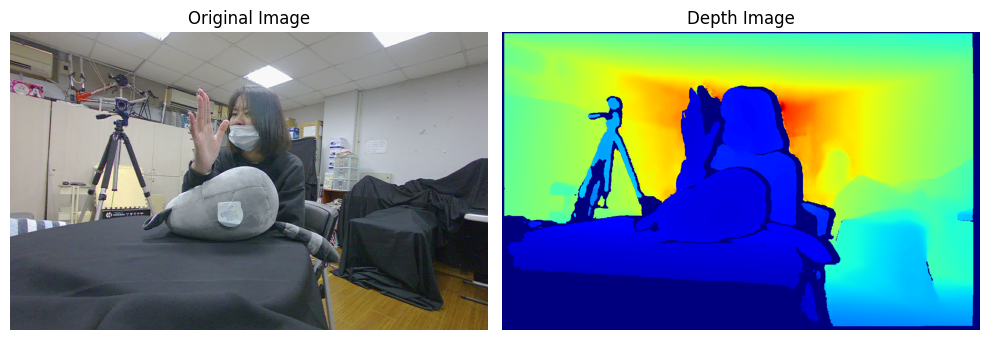

In [106]:
# Retrive the data for recording
recording_0 = processed_data.get("recording_0")
recording_1 = processed_data.get("recording_1")
recording_2 = processed_data.get("recording_2")

depth_images = recording_2["depth_images"]
color_images = recording_2["color_images"]

print(f"Length of data: {len(depth_images)}")

visualize_depth(color_images[0], depth_images[0])
rerun_visualization(color_images)

**Preprocess Data (Cropping to Target Hand)**

In [93]:
import albumentations as A
import cv2
import numpy as np

recording_0 = processed_data.get("recording_0")
recording_1 = processed_data.get("recording_1")
recording_2 = processed_data.get("recording_2")

def save_image(image, filename):
    # Convert into RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Save the image
    cv2.imwrite(filename, image)

def apply_transform(image):
    transformed = pipeline(image=image)
    return transformed['image']

pipeline = A.Compose([
    A.Crop(x_min=350, y_min=100, x_max=650, y_max=400, p=1),
])

save_image(apply_transform(recording_0["color_images"][0]), "recording_0_color_image.png")
save_image(apply_transform(recording_1["color_images"][0]), "recording_1_color_image.png")
save_image(apply_transform(recording_2["color_images"][0]), "recording_2_color_image.png")

**Segment Data into Five Classes**

In [127]:
import math

import math

def segment_data(data, extract_config=None, recording_id=None):
    """
    Segments the input data into 5 classes of exactly 16 frames each.
    For each class region (0–7, 16–23, 32–39, 48–55, 64–71), extracts up to
    `extract_per_class` frames (configurable per recording), then pads with
    the last extracted frame to reach 16. If a region is completely empty,
    pads with the very last frame of the recording.

    Classes (start indices):
      0: Hand Open
     16: Intrinsic Plan
     32: Straight Fist
     48: Hand Close
     64: Hook Hand

    Parameters:
        data (list): A sequence of frames (length n ≥ 0).
        extract_config (dict, optional): maps recording_id → extract_per_class.
        recording_id (str, optional): the key for this recording in extract_config.

    Returns:
        dict: Mapping from each class label to a list of 16 frames.
    """
    class_labels = [
        "Hand Open",
        "Intrinsic Plan",
        "Straight Fist",
        "Hand Close",
        "Hook Hand"
    ]
    required_per_class = 16
    default_extract = 8

    # Determine per-class extract count
    if extract_config and recording_id in extract_config:
        extract_per_class = extract_config[recording_id]
    else:
        extract_per_class = default_extract

    n = len(data)
    segments = {}

    for i, label in enumerate(class_labels):
        start_idx = i * required_per_class
        end_idx = start_idx + extract_per_class

        # Extract up to `extract_per_class` frames
        extracted = data[start_idx:end_idx]

        # If region empty, seed with last frame of entire recording
        if not extracted and n > 0:
            extracted = [data[-1]]

        # Now pad so we end up with exactly 16 frames,
        # always duplicating the *last* extracted frame
        ex_len = len(extracted)
        if ex_len < required_per_class:
            pad_count = required_per_class - ex_len
            segment = extracted + [extracted[-1]] * pad_count
        else:
            segment = extracted[:required_per_class]

        print(
            f"{label}: start {start_idx}, "
            f"extracted {ex_len} frame(s), "
            f"padded to {len(segment)}"
        )
        segments[label] = segment

    return segments


def visualize_frames_matplotlib(frame_list, n_cols=10, figsize=(20, 4)):
    n_frames = len(frame_list)
    n_rows = math.ceil(n_frames / n_cols)
    fig = plt.figure(figsize=figsize)
    
    for i, frame in enumerate(frame_list):
        # Create subplot for each frame; subplot numbering starts at 1
        ax = fig.add_subplot(n_rows, n_cols, i + 1, xticks=[], yticks=[])
        ax.imshow(frame)
        # Place text using normalized axis coordinates (0 to 1) to avoid truncation
        ax.text(0.05, 0.9, f'Frame {i}', transform=ax.transAxes,
                fontsize=14, color='white', clip_on=False,
                bbox=dict(facecolor='black', alpha=0.5, edgecolor='none'))
        ax.axis('off')
    
    # Adjust the layout to ensure nothing is clipped
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

def visualize_frames_rerun(segmented_data):
    """
    Visualizes frames from five segmented image lists using rr and rrb libraries.
    
    The segmented_data dictionary should contain the following keys:
      - "Hand Open"
      - "Intrinsic Plan"
      - "Straight Fist"
      - "Hand Close"
      - "Hook Hand"
      
    Each key maps to a list of image frames. This function iterates over the frames 
    concurrently from each list, logs them to the recording stream with a time sequence,
    and sends the blueprint to visualize them in a grid layout.
    """
    
    # Retrieve image lists from the segmented_data dictionary
    hand_open_list     = segmented_data.get("Hand Open")
    intrinsic_plan_list = segmented_data.get("Intrinsic Plan")
    straight_fist_list = segmented_data.get("Straight Fist")
    hand_close_list    = segmented_data.get("Hand Close")
    hook_hand_list     = segmented_data.get("Hook Hand")
    
    # Create a new recording stream with the "spawn" parameter
    stream = rr.new_recording("spawn", spawn=True)
    
    # Define the blueprint with a grid layout containing five spatial views
    blueprint = rrb.Blueprint(
        rrb.Grid(
            rrb.Spatial2DView(origin='/hand_open_image'),
            rrb.Spatial2DView(origin='/intrinsic_plan_image'),
            rrb.Spatial2DView(origin='/straight_fist_image'),
            rrb.Spatial2DView(origin='/hand_close_image'),
            rrb.Spatial2DView(origin='/hook_hand_image'),
        )
    )
    
    # Loop through all frames concurrently using zip and enumerate for proper looping.
    for idx, (hand_open, intrinsic_plan, straight_fist, hand_close, hook_hand) in enumerate(
        zip(hand_open_list, intrinsic_plan_list, straight_fist_list, hand_close_list, hook_hand_list)
    ):
        stream.set_time_sequence("frame", idx)
        stream.log("hand_open_image", rr.Image(hand_open))
        stream.log("intrinsic_plan_image", rr.Image(intrinsic_plan))
        stream.log("straight_fist_image", rr.Image(straight_fist))
        stream.log("hand_close_image", rr.Image(hand_close))
        stream.log("hook_hand_image", rr.Image(hook_hand))
    
    # Send the blueprint to complete the recording visualization
    stream.send_blueprint(blueprint)

extract_config = {
    "recording_0": 16,
    "recording_1": 8,
    "recording_2": 10
}

all_segmented = {}

for rec_id, rec_data in processed_data.items():
    color_list = rec_data["color_images"]
    # run segmentation on depth; you can do the same for color if desired
    segments = segment_data(
        data=color_list,
        extract_config=extract_config,
        recording_id=rec_id
    )
    all_segmented[rec_id] = segments

visualize_frames_rerun(all_segmented['recording_2'])

Hand Open: start 0, extracted 16 frame(s), padded to 16
Intrinsic Plan: start 16, extracted 16 frame(s), padded to 16
Straight Fist: start 32, extracted 16 frame(s), padded to 16
Hand Close: start 48, extracted 16 frame(s), padded to 16
Hook Hand: start 64, extracted 16 frame(s), padded to 16
Hand Open: start 0, extracted 8 frame(s), padded to 16
Intrinsic Plan: start 16, extracted 8 frame(s), padded to 16
Straight Fist: start 32, extracted 8 frame(s), padded to 16
Hand Close: start 48, extracted 8 frame(s), padded to 16
Hook Hand: start 64, extracted 8 frame(s), padded to 16
Hand Open: start 0, extracted 10 frame(s), padded to 16
Intrinsic Plan: start 16, extracted 10 frame(s), padded to 16
Straight Fist: start 32, extracted 10 frame(s), padded to 16
Hand Close: start 48, extracted 10 frame(s), padded to 16
Hook Hand: start 64, extracted 10 frame(s), padded to 16


#### MiDaS 3.0

RGB Image shape: (480, 640, 3)
Depth Image shape: (480, 640)


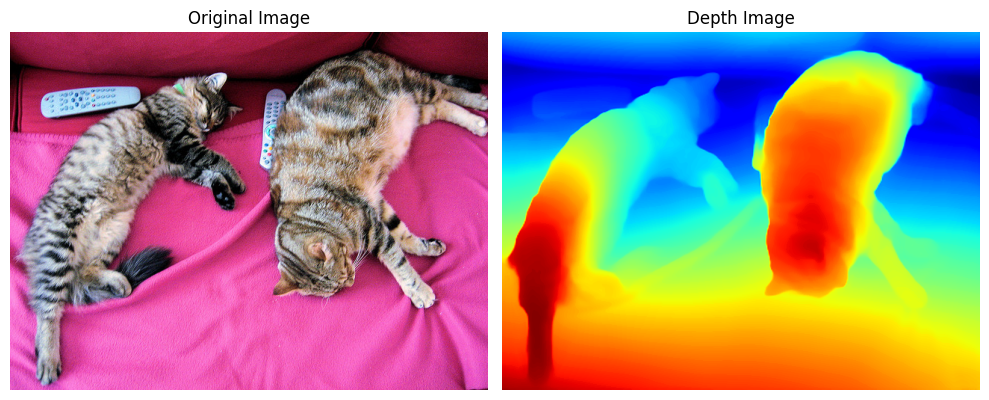

In [7]:
from PIL import Image
import numpy as np
import requests
import torch

from transformers import DPTImageProcessor, DPTForDepthEstimation

image_processor = DPTImageProcessor.from_pretrained("Intel/dpt-hybrid-midas")
model = DPTForDepthEstimation.from_pretrained("Intel/dpt-hybrid-midas", low_cpu_mem_usage=True)

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

# prepare image for the model
inputs = image_processor(images=image, return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)
    predicted_depth = outputs.predicted_depth

# interpolate to original size
prediction = torch.nn.functional.interpolate(
    predicted_depth.unsqueeze(1),
    size=image.size[::-1],
    mode="bicubic",
    align_corners=False,
)

# visualize the prediction
output = prediction.squeeze().cpu().numpy()
formatted = (output * 255 / np.max(output)).astype("uint8")

# Convert `image` and `formatted` into numpy array
image = np.array(image)
formatted = np.array(formatted)

visualize_depth(image, formatted)

## 3. Data Generation

### 1. Segment RAW `.bag` data into 5 classes and save into `.npy`

#### Image Data

**`.npy`**

In [69]:
import os
import copy
import numpy as np
import albumentations as A

# your existing transform pipeline
pipeline = A.Compose([
    A.Crop(x_min=350, y_min=100, x_max=650, y_max=400, p=1),
])

def apply_transform(image: np.ndarray) -> np.ndarray:
    image_transformed = copy.deepcopy(image)
    return pipeline(image=image_transformed)['image']

# root folder that contains the 'rgb' and 'depth' subfolders
base_save_dir = r'D:\RESEARCH ASSISTANT\6. Depth Camera\CODE\Orbbec Gemini 2XL\REMOTE\DEVELOPMENT\notebook\DATA\20250402\image'

# map the keys in processed_data to the desired subfolder names
modalities = {
    "color_images": "rgb",
    "depth_images": "depth",
}

for recording_name, recording in processed_data.items():
    # e.g. recording_name == "recording_0", recording is a dict
    for data_key, subfolder in modalities.items():
        images = recording[data_key]                     # list of np.ndarrays
        segmented = segment_data(images)                 # dict: class_name -> list of frames

        for class_name, frames in segmented.items():
            # make folder-safe class name, e.g. "Hand Open" -> "Hand_Open"
            safe_class = class_name.replace(" ", "_")

            # build output directory:
            # <base>/rgb/Hand_Open  or  <base>/depth/Hook_Hand
            out_dir = os.path.join(base_save_dir, subfolder, safe_class)
            os.makedirs(out_dir, exist_ok=True)

            # save each frame
            for idx, frame in enumerate(frames):
                transformed = apply_transform(frame)
                fname = f"{recording_name}_{safe_class}_{idx:03d}.npy"
                path = os.path.join(out_dir, fname)
                np.save(path, transformed)


**PNG**

In [128]:
import os
import copy
import numpy as np
import albumentations as A
from PIL import Image

# 1) your existing transform pipeline
pipeline = A.Compose([
    A.Crop(x_min=350, y_min=100, x_max=650, y_max=400, p=1),
])

def apply_transform(image: np.ndarray) -> np.ndarray:
    image_transformed = copy.deepcopy(image)
    return pipeline(image=image_transformed)['image']

# 2) segmentation configuration (how many frames to extract per recording)
extract_config = {
    "recording_0": 16,
    "recording_1": 8,
    "recording_2": 10
}

# 3) save each frame as .png
base_save_dir = r'D:\RESEARCH ASSISTANT\6. Depth Camera\CODE\Orbbec Gemini 2XL\REMOTE\DEVELOPMENT\notebook\DATA\20250402\image_png'

for recording_name, recording in processed_data.items():
    # run segmentation with updated signature
    segmented = segment_data(
        data=recording['color_images'],
        extract_config=extract_config,
        recording_id=recording_name
    )

    for class_name, frames in segmented.items():
        safe_class = class_name.replace(" ", "_")
        out_dir = os.path.join(base_save_dir, safe_class)
        os.makedirs(out_dir, exist_ok=True)

        for idx, frame in enumerate(frames):
            tf = apply_transform(frame)               # H×W×3 uint8 or float
            # if float in [0,1], scale to [0,255]:
            if tf.dtype != np.uint8:
                tf = (tf * 255).astype(np.uint8)
            img = Image.fromarray(tf)
            fname = f"{recording_name}_{safe_class}_{idx:03d}.png"
            img.save(os.path.join(out_dir, fname))


Hand Open: start 0, extracted 16 frame(s), padded to 16
Intrinsic Plan: start 16, extracted 16 frame(s), padded to 16
Straight Fist: start 32, extracted 16 frame(s), padded to 16
Hand Close: start 48, extracted 16 frame(s), padded to 16
Hook Hand: start 64, extracted 16 frame(s), padded to 16
Hand Open: start 0, extracted 8 frame(s), padded to 16
Intrinsic Plan: start 16, extracted 8 frame(s), padded to 16
Straight Fist: start 32, extracted 8 frame(s), padded to 16
Hand Close: start 48, extracted 8 frame(s), padded to 16
Hook Hand: start 64, extracted 8 frame(s), padded to 16
Hand Open: start 0, extracted 10 frame(s), padded to 16
Intrinsic Plan: start 16, extracted 10 frame(s), padded to 16
Straight Fist: start 32, extracted 10 frame(s), padded to 16
Hand Close: start 48, extracted 10 frame(s), padded to 16
Hook Hand: start 64, extracted 10 frame(s), padded to 16


#### Video Data

**`.npy`**

In [70]:
import os
import copy
import numpy as np
import albumentations as A

# your existing transform pipeline
pipeline = A.Compose([
    A.Crop(x_min=350, y_min=100, x_max=650, y_max=400, p=1),
])

def apply_transform(image: np.ndarray) -> np.ndarray:
    image_transformed = copy.deepcopy(image)
    return pipeline(image=image_transformed)['image']

base_save_dir = r'D:\RESEARCH ASSISTANT\6. Depth Camera\CODE\Orbbec Gemini 2XL\REMOTE\DEVELOPMENT\notebook\DATA\20250402\video'
modalities = {
    "color_images": "rgb",
    "depth_images": "depth",
}

for recording_name, recording in processed_data.items():
    for data_key, subfolder in modalities.items():
        images = recording[data_key]                     # list of np.ndarrays
        segmented = segment_data(images)                 # dict: class_name -> list of frames

        for class_name, frames in segmented.items():
            safe_class = class_name.replace(" ", "_")
            out_dir = os.path.join(base_save_dir, subfolder, safe_class)
            os.makedirs(out_dir, exist_ok=True)

            # transform + normalize channel dims
            transformed_frames = []
            for frame in frames:
                tf = apply_transform(frame)
                # if depth: expand HxW -> HxW×1
                if subfolder == "depth" and tf.ndim == 2:
                    tf = tf[:, :, None]
                transformed_frames.append(tf)

            # stack into (T, H, W, C)
            video = np.stack(transformed_frames, axis=0)
            # reorder to (C, T, H, W)
            video = video.transpose(3, 0, 1, 2)

            # save one file per recording/class
            fname = f"{recording_name}_{safe_class}.npy"
            path = os.path.join(out_dir, fname)
            np.save(path, video)


**`.mp4`**

In [129]:
import os
import copy
import numpy as np
import albumentations as A
import imageio

# 1) your existing transform pipeline
pipeline = A.Compose([
    A.Crop(x_min=350, y_min=100, x_max=650, y_max=400, p=1),
])

def apply_transform(image: np.ndarray) -> np.ndarray:
    image_transformed = copy.deepcopy(image)
    return pipeline(image=image_transformed)['image']

# 2) segmentation configuration (how many frames to extract per recording)
extract_config = {
    "recording_0": 16,
    "recording_1": 8,
    "recording_2": 10
}

# 3) write out entire clip as an MP4 (fixed to avoid the “row iteration” bug)
base_save_dir = r'D:\RESEARCH ASSISTANT\6. Depth Camera\CODE\Orbbec Gemini 2XL\REMOTE\DEVELOPMENT\notebook\DATA\20250402\video_mp4'

for recording_name, recording in processed_data.items():
    # run segmentation with the updated signature
    segmented = segment_data(
        data=recording['color_images'],
        extract_config=extract_config,
        recording_id=recording_name
    )

    for class_name, frames in segmented.items():
        safe_class = class_name.replace(" ", "_")
        out_dir = os.path.join(base_save_dir, safe_class)
        os.makedirs(out_dir, exist_ok=True)

        # collect all transformed frames
        transformed = []
        for frame in frames:
            tf = apply_transform(frame)
            # ensure uint8 H×W×3
            if tf.dtype != np.uint8:
                tf = (tf * 255).astype(np.uint8)
            transformed.append(tf)

        # write MP4 in one call so PyAV sees full-frame arrays
        video_path = os.path.join(out_dir, f"{recording_name}_{safe_class}.mp4")
        with imageio.get_writer(video_path, fps=10, codec='libx264') as writer:
            writer.append_data(transformed)


Hand Open: start 0, extracted 16 frame(s), padded to 16
Intrinsic Plan: start 16, extracted 16 frame(s), padded to 16
Straight Fist: start 32, extracted 16 frame(s), padded to 16
Hand Close: start 48, extracted 16 frame(s), padded to 16
Hook Hand: start 64, extracted 16 frame(s), padded to 16
Hand Open: start 0, extracted 8 frame(s), padded to 16
Intrinsic Plan: start 16, extracted 8 frame(s), padded to 16
Straight Fist: start 32, extracted 8 frame(s), padded to 16
Hand Close: start 48, extracted 8 frame(s), padded to 16
Hook Hand: start 64, extracted 8 frame(s), padded to 16
Hand Open: start 0, extracted 10 frame(s), padded to 16
Intrinsic Plan: start 16, extracted 10 frame(s), padded to 16
Straight Fist: start 32, extracted 10 frame(s), padded to 16
Hand Close: start 48, extracted 10 frame(s), padded to 16
Hook Hand: start 64, extracted 10 frame(s), padded to 16
